In [1]:
import sys
import warnings
warnings.filterwarnings(action="ignore")
sys.path.append('../../src')


In [2]:
from dora.models.clay import wrapper
from dora.data import norm

import numpy as np
from glob import glob
import rasterio


In [8]:
from importlib import reload
reload(norm)

<module 'dora.data.norm' from '/home/raulramos/2024-dora/notebooks/sentinel2/../../src/dora/data/norm.py'>

# compute mean std per channel with small sample

In [9]:
k = norm.compute_normalization_constants(file_spec = '/opt/buckets/disasterbrain-data/chips/chipsets/*/s2rgb-2024/*.tif')

2024-12-18 03:02:40.953 | INFO     | dora.data.norm:compute_normalization_constants:55 - looking for files under /opt/buckets/disasterbrain-data/chips/chipsets/*/s2rgb-2024/*.tif
2024-12-18 03:03:05.564 | INFO     | dora.data.norm:compute_normalization_constants:58 - found 338545 files
2024-12-18 03:03:05.565 | INFO     | dora.data.norm:compute_normalization_constants:59 - sampling and reading 1024 files in parallel
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done 1024 out of 1024 | elapsed:   59.3s finished
2024-12-18 03:04:04.847 | INFO     | dora.data.norm:comput

In [10]:
k

{'mean': array([49.68642017, 41.68397809, 33.60154635]),
 'std': array([48.56573486, 42.10673072, 42.79211015])}

# get some embeddings

In [7]:
len(files)

337032

In [11]:
files = np.r_[glob('/opt/buckets/disasterbrain-data/chips/chipsets/*/s2rgb-2024/*.tif')]

In [12]:
len(files)

339513

In [28]:
CHECKPOINT_PATH = "/opt/claymodel-weights/clay-v1.5.ckpt"
METADATA_PATH = "/opt/claymodel-weights/metadata.yaml"

cw = wrapper.ClayWrapper(metadata_path=METADATA_PATH, checkpoint_path=CHECKPOINT_PATH)

2024-12-18 03:11:01.112 | INFO     | dora.models.clay.wrapper:__init__:18 - using device cpu
2024-12-18 03:11:01.115 | INFO     | dora.models.clay.wrapper:__init__:20 - creating clay model instance
2024-12-18 03:11:08.362 | INFO     | dora.models.clay.wrapper:__init__:37 - loading clay model weights
2024-12-18 03:11:14.927 | INFO     | dora.models.clay.wrapper:__init__:45 - done


In [23]:
n_samples = 22

In [24]:
batch_size = 4

In [44]:
_sampled_files = files if n_samples is None else np.random.permutation(files)[:n_samples]

In [51]:
import os
import pickle

dest_dir = '/opt/claymodel-embeddings'

sampled_files = []

# do only the files for which there are no embeddings
for file in _sampled_files:
    chipset = file.split('/')[-3]
    chip = file.split('/')[-1].split('.')[0]

    chipset_folder = f'{dest_dir}/{chipset}'
    embeddings_file = f'{chipset_folder}/{chip}.pkl'    

    if not os.path.isfile(embeddings_file):
        sampled_files.append(file)
    
len(sampled_files)

22

In [96]:
nsteps = len(sampled_files) // batch_size
if nsteps % batch_size != 0:
    nsteps += 1
    
for j in range(nsteps):
    print (j*batch_size, (j+1) * batch_size)

0 4
4 8
8 12
12 16
16 20
20 24


In [91]:
n_steps

NameError: name 'n_steps' is not defined

In [64]:
from joblib import Parallel, delayed
i=0
while i<len(sampled_files):
    i+=batch_size

    batch_files = sampled_files[i:i+batch_size]

    # assemble batch 
    def loadimg(file):
        with rasterio.open(file) as f:
            x = f.read()
        return x
        
    batch = np.r_[Parallel(n_jobs=-1, verbose=0)(delayed(loadimg)(file) for file in batch_files)]
    
    # get embeddings
    e = cw.batch_embeddings(batch).numpy()
    break

In [65]:
e.shape

(4, 4, 1024)

In [66]:
for i, file in enumerate(batch_files):
    
    chipset = file.split('/')[-3]
    chip = file.split('/')[-1].split('.')[0]

    chipset_folder = f'{dest_dir}/{chipset}'
    embeddings_file = f'{chipset_folder}/{chip}.pkl'    

    if not os.path.isdir(chipset_folder):
        os.makedirs(chipset_folder, exist_ok=True)


    ei = {'winter': e[i,0], 'spring': e[i,1], 'summer': e[i,2], 'fall': e[i,3]}

    with open(embeddings_file, 'wb') as f:
        pickle.dump(ei, f)
        


In [78]:
from progressbar import ProgressBar

In [79]:
pbar = ProgressBar(max_value=10)

In [83]:
pbar.next()

 30% (3 of 10) |#######                  | Elapsed Time: 0:00:03 ETA:   0:00:07

2

In [67]:
batch_files

[np.str_('/opt/buckets/disasterbrain-data/chips/chipsets/0dfb700ca0273_partitions_aschips_12e4fbafb89bb/s2rgb-2024/0e3becf1b5ff0.tif'),
 np.str_('/opt/buckets/disasterbrain-data/chips/chipsets/132ff047f2e56_partitions_aschips_2931ccad5f05a/s2rgb-2024/08ae24d05a137.tif'),
 np.str_('/opt/buckets/disasterbrain-data/chips/chipsets/2da13a4459bcc_partitions_aschips_34dcad58b8ae0/s2rgb-2024/0c157a2d3df63.tif'),
 np.str_('/opt/buckets/disasterbrain-data/chips/chipsets/132ff047f2e56_partitions_aschips_2931ccad5f05a/s2rgb-2024/1cd2c2a6bec0a.tif')]

In [70]:
with open(embeddings_file, 'rb') as f:
    ei = pickle.load(f)

In [71]:
{k:v.shape for k,v in ei.items()}

{'winter': (1024,), 'spring': (1024,), 'summer': (1024,), 'fall': (1024,)}

In [36]:
for file in batch_files:
    break
file

np.str_('/opt/buckets/disasterbrain-data/chips/chipsets/3773547641897_partitions_aschips_1318c3e97e3e9/s2rgb-2024/1f70cc2c18480.tif')

In [ ]:
file.split(

In [5]:
from progressbar import progressbar as pbar
batch_size = 4
batch_idxs = np.random.permutation(len(files))[:batch_size]
batch_files = np.r_[files][batch_idxs]

original_batch = []

for file in pbar(batch_files):
    with rasterio.open(file) as f:
        x = f.read()
        d = f.descriptions

    original_batch.append(x)

100% (4 of 4) |##########################| Elapsed Time: 0:00:04 Time:  0:00:040:01


In [6]:
original_batch = np.r_[original_batch]
original_batch.shape

(4, 12, 512, 512)

In [7]:

CHECKPOINT_PATH = "/opt/claymodel-weights/clay-v1.5.ckpt"
METADATA_PATH = "/opt/claymodel-weights/metadata.yaml"

cw = wrapper.ClayWrapper(metadata_path=METADATA_PATH, checkpoint_path=CHECKPOINT_PATH)

2024-12-18 02:46:43.433 | INFO     | dora.models.clay.wrapper:__init__:18 - using device cpu
2024-12-18 02:46:43.436 | INFO     | dora.models.clay.wrapper:__init__:20 - creating clay model instance
2024-12-18 02:46:48.986 | INFO     | dora.models.clay.wrapper:__init__:37 - loading clay model weights
2024-12-18 02:46:51.391 | INFO     | dora.models.clay.wrapper:__init__:45 - done


In [8]:
e = cw.batch_embeddings(original_batch)

In [9]:
e.shape

torch.Size([4, 4, 1024])

In [10]:
e1 = cw.batch_embeddings(original_batch[2:3])
e1.shape

torch.Size([1, 4, 1024])

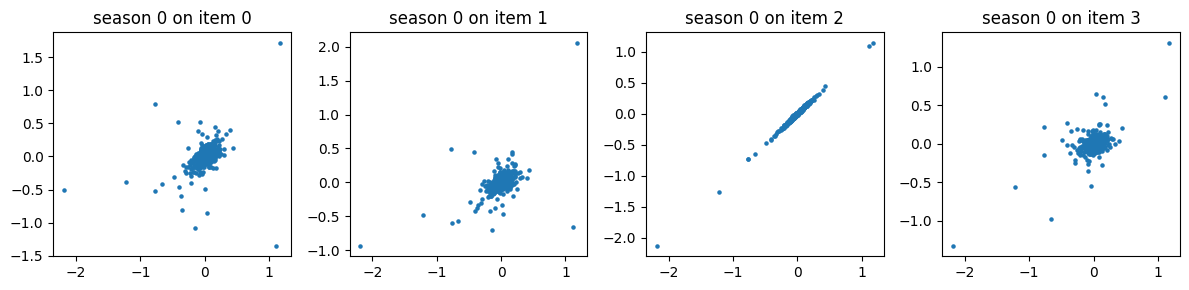

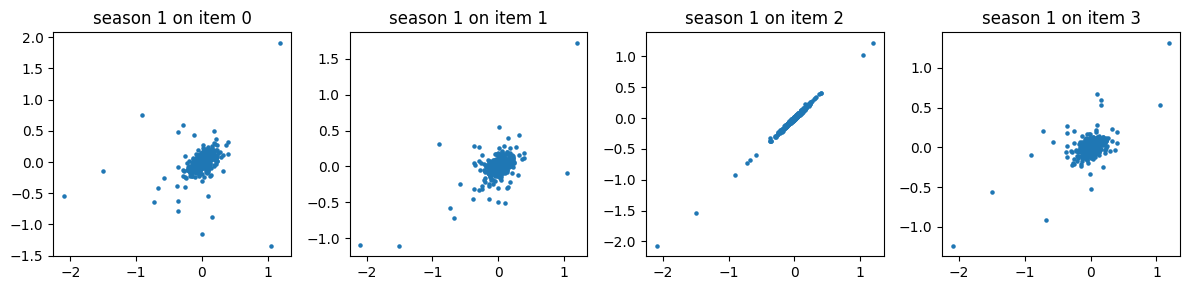

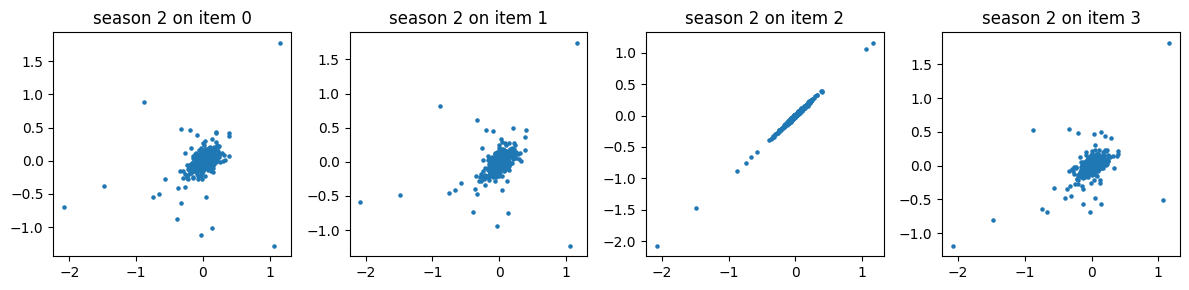

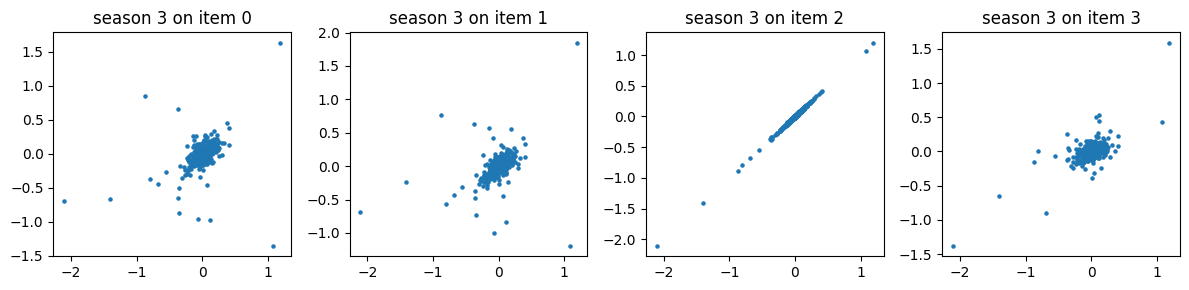

In [12]:
from rlxutils import subplots
import matplotlib.pyplot as plt
for i in range(4):
    for ax,j in subplots(len(e)):
        plt.scatter(e1[0, i], e[j,i],s=5)
        plt.title(f"season {i} on item {j}")

In [289]:
original_batch = np.r_[original_batch]
original_batch.shape

(1, 12, 512, 512)

In [290]:
original_batch.reshape(len(original_batch), -1).sum(axis=1)

array([156031224], dtype=uint64)

In [394]:
batch = np.r_[[img[3*i:3*(i+1)] for img in original_batch for i in range(4)]][:4]
batch.shape

(4, 3, 512, 512)

In [395]:
batch.reshape(len(batch), -1).sum(axis=1)

array([55663417, 26099427, 37250888, 37017492], dtype=uint64)

In [396]:
np.r_[[original_batch[j,i*3:(i+1)*3].sum()  for j in range(len(original_batch)) for i in range(4)]]

array([55663417, 26099427, 37250888, 37017492], dtype=uint64)

In [397]:
batch_normalized = np.transpose((np.transpose(batch, [0,2,3,1]) - s.mean) / s.std, [0,3,1,2])
batch_normalized.shape

(4, 3, 512, 512)

In [398]:
batch_normalized.reshape(len(batch), -1).shape

(4, 786432)

In [399]:
np.r_[[sum([((batch[i,j]-s.mean[j])/s.std[j]).sum()  for j in range(batch.shape[1])]) for i in range(batch.shape[0]) ]]

array([ 448772.51036937, -193791.74289041,   41623.74772569,
         36623.39849423])

In [400]:
batch_normalized.reshape(len(batch_normalized), -1).sum(axis=1)

array([ 448772.51036937, -193791.74289041,   41623.74772569,
         36623.39849423])

In [401]:
batch_normalized.reshape(len(batch_normalized), -1).sum(axis=1)

array([ 448772.51036937, -193791.74289041,   41623.74772569,
         36623.39849423])

In [402]:
batch_normalized.sum(axis=1).sum(axis=1).sum(axis=1)

array([ 448772.51036937, -193791.74289041,   41623.74772569,
         36623.39849423])

In [403]:
batch_normalized.shape

(4, 3, 512, 512)

In [404]:
tbatch = batch_normalized[:4]
x = {'pixels': torch.tensor(tbatch).type(torch.float),
     'time': torch.zeros([len(tbatch), 4]),
     'latlon': torch.zeros([len(tbatch), 4]),
     'gsd': torch.tensor(10.),
     'waves': torch.tensor([1552., 1355., 1105.])} # rgb freqs


In [405]:
module.model.patch_size

8

In [406]:
from time import time

In [420]:
t0 = time()
with torch.no_grad():
    embeddings_raw, *_ = module.model.encoder(x)

patch_size = module.model.patch_size
image_size = original_batch.shape[-1]
# compute patch and image embeddings
patch_embeddings = rearrange(
    embeddings_raw[:, :-1, :], # :-1; last embedding is the cls_token
    "b (h w) d -> b h w d",
    w=image_size//patch_size//2,
    h=image_size//patch_size//2,
)
image_embeddings = reduce(patch_embeddings, "b h w d -> b d", "mean")
time() - t0

4.963301420211792

In [414]:
#image_embeddings_four = image_embeddings

In [386]:
#image_embeddings_two = image_embeddings

In [388]:
#image_embeddings_onlyone = image_embeddings

In [389]:
image_embeddings_onlyone.sum(axis=1)

tensor([-1.6256])

In [390]:
image_embeddings_onlyone.sum(axis=1)

tensor([-1.6256])

In [391]:
image_embeddings_two.sum(axis=1)

tensor([-1.4080,  1.0120])

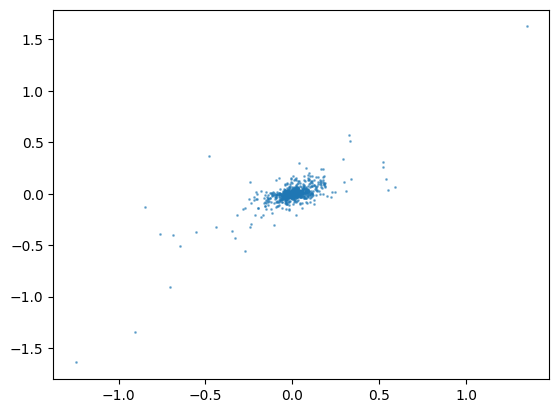

In [418]:
plt.scatter(image_embeddings_four[1], image_embeddings_two[0], s=1, alpha=.5)

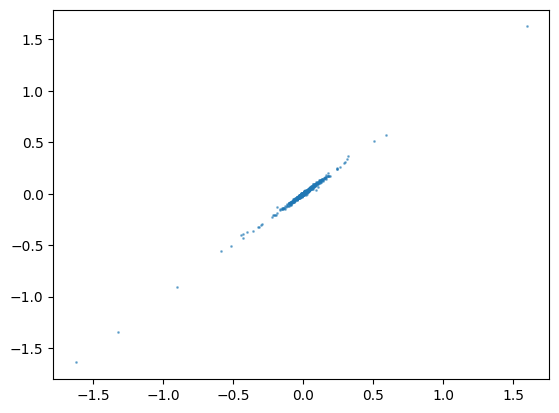

In [393]:
plt.scatter(image_embeddings_onlyone[0], image_embeddings_two[0], s=1, alpha=.5)

In [335]:
image_embeddings.sum(axis=1)

tensor([1.8339, 3.0115])

## embeddings sums

In [255]:
e1.sum(axis=1)

tensor([2052282])

In [235]:
e1.sum(axis=1)

tensor([2064394])

In [250]:
e1.sum(axis=1)

tensor([2082951, 2076314])

In [204]:
e1.sum(axis=1)

tensor([2086190, 2098356, 2085219, 2110659, 2058090, 2083083, 2076559, 2067091])

In [202]:
e1.reshape(len(batch_files), -1, e1.shape[-1]).sum(axis=1).sum(axis=1)

tensor([8380424, 8284823])

In [203]:
e1.reshape(len(batch_files), -1, e1.shape[-1]).sum(axis=1).sum(axis=1)

tensor([8380424, 8284823])

In [75]:
e1.reshape(len(batch_files), -1, e1.shape[-1]).sum(axis=1).sum(axis=1)

tensor([8328307, 8420362])

In [41]:
len(batch_files)

16

In [ ]:
16 -> 73 secs
8 -> 42 secs
4 -> 21 secs
2 -> 21 secs

In [ ]:
torch.tensor(batch)

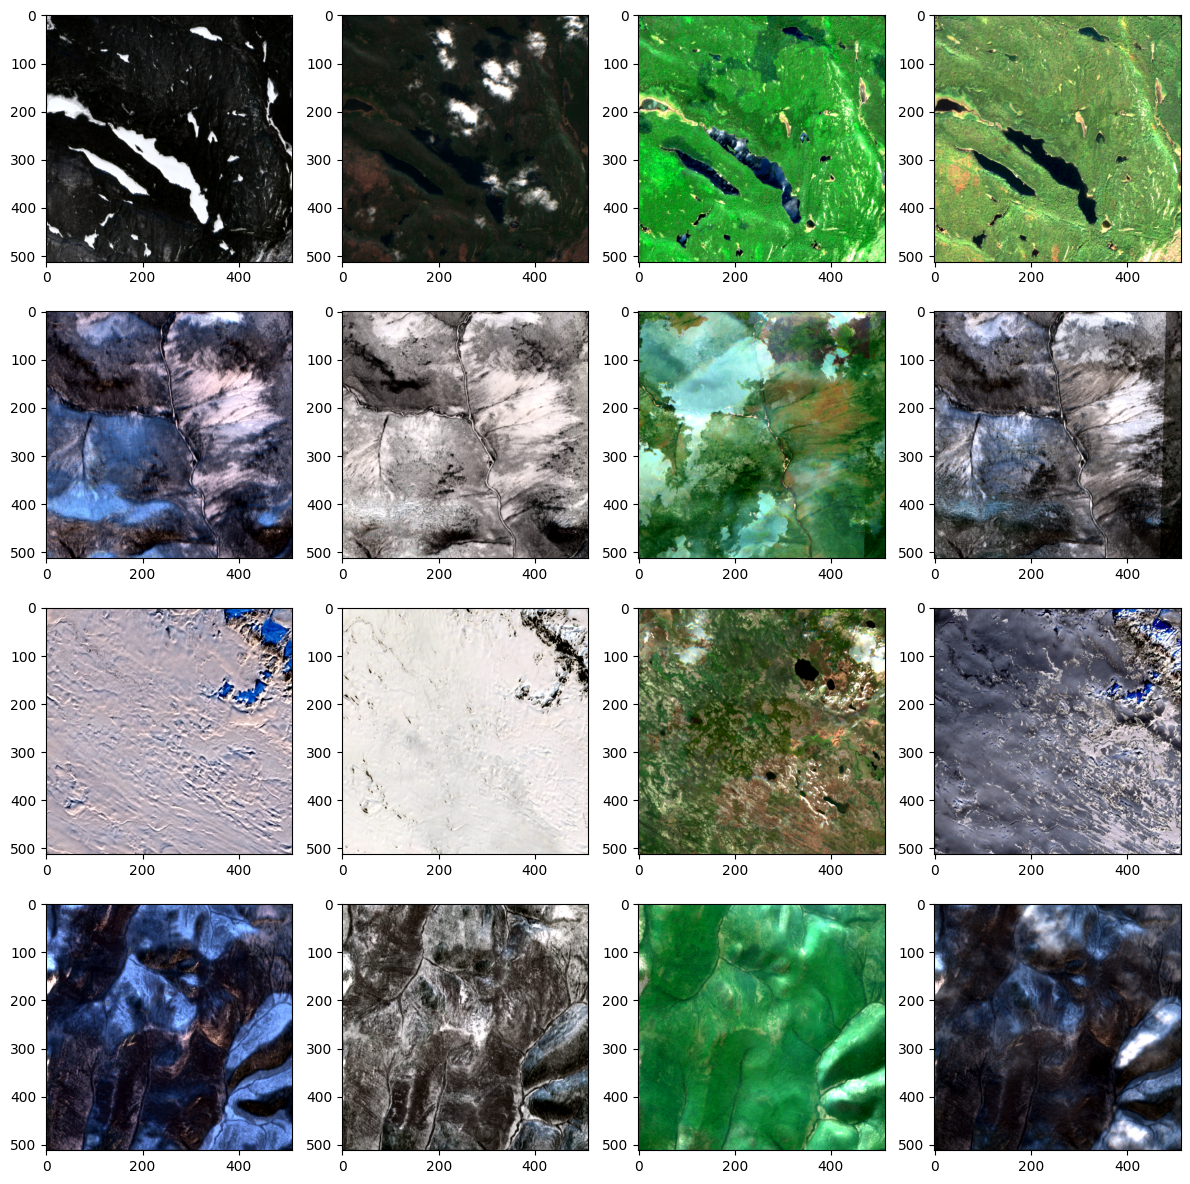

In [33]:
from rlxutils import subplots

for ax,i in subplots(len(batch), n_cols=4):
    xs = np.transpose(batch[i], [1,2,0]) / 255
    a,b = np.percentile(xs, (1,99))
    xs = (xs-a)/(b-a)
    xs[xs<0]=0
    xs[xs>1]=1
    plt.imshow(xs)


In [22]:
i=0
img = np.r_[[img[3*i:3*(i+1)] for i in range(4)]]

(4, 3, 512, 512)

In [ ]:
x = {'pixels': torch.rand([8,3,256,256]),
     'time': torch.rand([8,4]),
     'latlon': torch.rand([8,4]),
     'gsd': torch.rand(1),
     'waves': torch.tensor([1552., 1355., 1105.])} # rgb freqs
